In [1]:
import os
import os.path as osp
from collections import defaultdict, Counter
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import wordnet as wn
from scipy.stats import chi2_contingency

from analysis_utils import (
    read_ann_df, get_hyponyms,
    mean_reciprocal_rank,
    transform_list_into_heads
    )

pd.options.mode.chained_assignment = None  # default='warn'

IMG_LOCATION=osp.abspath('../generated_items/')

data_dir = osp.abspath('../scenegram_data')
kilogram_dir = osp.abspath('../kilogram')

nlp = spacy.load("en_core_web_sm")

fig_out_dir = osp.abspath(osp.join(os.pardir, 'collected_data', 'figures', 'label_analysis'))
if not osp.isdir(fig_out_dir):
    os.makedirs(fig_out_dir)

In [2]:
input_file = osp.join(data_dir, 'scenegram.csv')
ann_df = read_ann_df(input_file)

tangrams, scenes = zip(*ann_df.index)
tangrams = sorted(set(tangrams))
scenes = sorted(set(scenes))
# 'none' as last scene
scenes.remove('none')
scenes.append('none')

display(ann_df.head())

# make df with kilogram anns
def unpack_anns(list_of_annotations):
    return [x['whole']['wholeAnnotation'] for x in list_of_annotations]

kilogram_path = osp.join(kilogram_dir, 'dataset', 'dense.json')
kilogram_df = pd.read_json(kilogram_path).T
kilogram_df = kilogram_df.loc[tangrams]

kilogram_df['annotation_strings'] = kilogram_df.annotations.map(unpack_anns)

# extract heads with spacy
kilogram_df['annotation_heads'] = kilogram_df.annotation_strings.map(lambda x: transform_list_into_heads(x, nlp, normalize=True))

display(kilogram_df.head())

item_identifyer           raw_annotation  \
tangram scene                                                   
page-D  bathroom  3-bathroom-sws2_10    person reading a book   
        bathroom   3-bathroom-sws2_0       bathroom attendant   
        bathroom   3-bathroom-sws2_1                   PRIEST   
        bathroom  3-bathroom-sws2_15                   sliver   
        bathroom   3-bathroom-sws2_6  person holding arms out   

                         clean_annotation           head_noun   wn_lemma  \
tangram scene                                                              
page-D  bathroom    person reading a book              person     person   
        bathroom       bathroom attendant  bathroom attendant  attendant   
        bathroom                   priest              priest     priest   
        bathroom                   sliver              sliver   splinter   
        bathroom  person holding arms out              person     person   

                 selected_synset  \
tangram scene                      
page-D  bathroom     person.n.01   
        bathroom  attendant.n.01   
        bathroom     priest.n.01   
        bathroom   splinter.n.01   
        bathroom     person.n.01   

                                                  synset_definition  \
tangram scene                                                         
page-D  bathroom                                      a human being   
        bathroom  someone who waits on or tends to or attends to...   
        bathroom  a clergyman in Christian churches who has the ...   
        bathroom   a small thin sharp bit or wood or glass or metal   
        bathroom                                      a human being   

                  tangram_id  item_id        image_url partition_name  \
tangram scene                                                           
page-D  bathroom           3       35  035_grid_tr.png           sws2   
        bathroom           3       35  035_grid_tr.png           sws2   
        bathroom           3       35  035_grid_tr.png           sws2   
        bathroom           3       35  035_grid_tr.png           sws2   
        bathroom           3       35  035_grid_tr.png           sws2   

                 workspace_name tangram_pos  order_idx  time_delta  
tangram scene                                                       
page-D  bathroom        sws2_10          tr          9  208.936461  
        bathroom         sws2_0          tr          5  435.840241  
        bathroom         sws2_1          tr          3  130.278864  
        bathroom        sws2_15          tr         27  347.661279  
        bathroom         sws2_6          tr         32  408.685458

,snd,pnd,psa,annotations,annotation_strings,annotation_heads
page-D,0.936195,0.662831,4.972391,[{'whole': {'timestamp': '2021-07-29 05:53:45....,"[men, a person standing in prayer, praying man...","[men, person, man, man, man, human, man, boat,..."
page-H,0.925589,0.751835,4.915825,[{'whole': {'timestamp': '2021-07-29 05:42:37....,"[joker, light lamp, toy, human, man, old man l...","[joker, lamp, toy, human, man, man, house, tri..."
page1-0,0.954052,0.906744,4.447025,[{'whole': {'timestamp': '2021-07-27 03:05:31....,"[seat, fist, building, a series of mountains, ...","[seat, fist, building, series, boat, building,..."
page1-116,0.873544,0.912755,6.222921,[{'whole': {'timestamp': '2021-07-01 17:47:32....,"[smoking chimney, well, a well, lamp, light, l...","[chimney, well, well, lamp, light, lamb, fire ..."
page1-128,0.978075,0.960254,5.525507,"[{'whole': {'wholeAnnotation': 'an open lock',...","[an open lock, telephone, cleaver, stove, furn...","[lock, telephone, cleaver, stove, furnace, Non..."


# Most frequent labels with Chi2 analysis (Table 2)

In [3]:
n_most_frequent = 5
prec = 2

def counts_to_perc(c, total, prec=prec):
    return round((c / total) * 100, prec)

def apply_bold_font(val):
    return f'font-weight:bold;' if val else None

def apply_bold_font_latex(val):
    return f'textbf:--rwrap;' if val else None

# get lexical counts
_df = ann_df.reset_index()
raw_counts = _df.groupby('scene').agg(list).wn_lemma.map(Counter)
most_common_per_scene = raw_counts.map(lambda x: x.most_common(n_most_frequent))

# go through words and conduct chi2 test
results = defaultdict(list)
for scene in scenes:
    scene_counts = raw_counts[scene]
    bl_counts = raw_counts['none']
    
    for i, (word, s_count) in enumerate(most_common_per_scene[scene]):
        s_non_count = sum([v for k, v in scene_counts.items() if k != word])
        b_count = sum([v for k, v in bl_counts.items() if k == word])
        b_non_count = sum([v for k, v in bl_counts.items() if k != word])
        
        observations = np.array([[s_count, s_non_count], [b_count, b_non_count]])
        chi2, p, dof, expected = chi2_contingency(observations)
        results[scene].append([word, s_count, p < 0.05, chi2, p])
        
# compile results
results_df = pd.DataFrame(results).T

total_per_scene = sum(raw_counts.iloc[0].values())
words_and_counts = results_df.applymap(lambda x: f'{x[0]} ({counts_to_perc(x[1], total_per_scene)} \%)')

# style significant entries and display / print results
m = results_df.applymap(lambda x: x[2])  # binary mask: True if p < 0.05 else False

df_styled = words_and_counts.style.apply(lambda x: m.applymap(apply_bold_font), axis=None)
display(df_styled)

# LaTeX output
df_styled = words_and_counts.style.apply(lambda x: m.applymap(apply_bold_font_latex), axis=None)
print(df_styled.to_latex())

,0,1,2,3,4
bathroom,person (7.57 \%),dog (3.78 \%),sink (3.24 \%),table (2.16 \%),wrench (2.16 \%)
beach,person (5.41 \%),dog (4.32 \%),crab (3.51 \%),horse (2.43 \%),K (2.16 \%)
bedroom,person (6.49 \%),dog (4.32 \%),bed (3.78 \%),lamp (3.51 \%),table (2.16 \%)
forest,person (7.3 \%),dog (4.05 \%),bird (2.43 \%),house (2.16 \%),forest (1.89 \%)
kitchen,person (5.68 \%),dog (5.68 \%),cabinet (2.7 \%),table (2.43 \%),bird (2.43 \%)
mountain,mountain (6.22 \%),person (5.14 \%),bird (2.97 \%),dog (2.43 \%),rock (1.89 \%)
office,person (7.84 \%),desk (4.32 \%),table (3.24 \%),dog (2.97 \%),lamp (2.43 \%)
sea_bottom,person (4.59 \%),fish (4.59 \%),turtle (2.43 \%),dog (2.43 \%),table (2.16 \%)
sky,person (5.41 \%),bird (4.86 \%),dog (4.05 \%),cloud (3.24 \%),mountain (2.43 \%)
street,person (7.57 \%),dog (4.59 \%),crab (2.7 \%),house (1.89 \%),bird (1.89 \%)


\begin{tabular}{llllll}
 & 0 & 1 & 2 & 3 & 4 \\
bathroom & person (7.57 \%) & dog (3.78 \%) & \textbf{sink (3.24 \%)} & table (2.16 \%) & \textbf{wrench (2.16 \%)} \\
beach & person (5.41 \%) & dog (4.32 \%) & crab (3.51 \%) & horse (2.43 \%) & K (2.16 \%) \\
bedroom & person (6.49 \%) & dog (4.32 \%) & \textbf{bed (3.78 \%)} & \textbf{lamp (3.51 \%)} & table (2.16 \%) \\
forest & person (7.3 \%) & dog (4.05 \%) & bird (2.43 \%) & house (2.16 \%) & \textbf{forest (1.89 \%)} \\
kitchen & person (5.68 \%) & dog (5.68 \%) & \textbf{cabinet (2.7 \%)} & table (2.43 \%) & bird (2.43 \%) \\
mountain & \textbf{mountain (6.22 \%)} & person (5.14 \%) & bird (2.97 \%) & \textbf{dog (2.43 \%)} & \textbf{rock (1.89 \%)} \\
office & person (7.84 \%) & \textbf{desk (4.32 \%)} & table (3.24 \%) & dog (2.97 \%) & lamp (2.43 \%) \\
sea_bottom & person (4.59 \%) & \textbf{fish (4.59 \%)} & turtle (2.43 \%) & \textbf{dog (2.43 \%)} & table (2.16 \%) \\
sky & person (5.41 \%) & bird (4.86 \%) & dog (4.05 \

# Most frequent lexical fields (via WordNet, Figure 9)

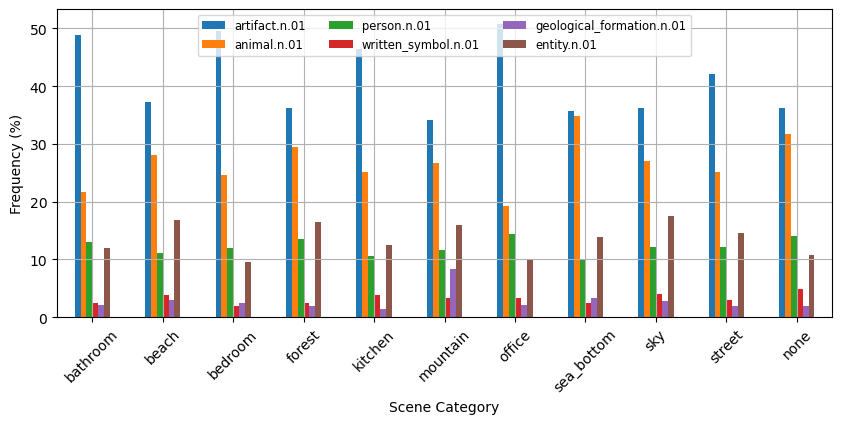

In [4]:
ref_synsets = [
    'artifact.n.01', 
    'animal.n.01', 
    'person.n.01', 
    'written_symbol.n.01',
    'geological_formation.n.01',
    'entity.n.01',
    ]

hypernym_map = dict()
hyponym_map = dict()

def assign_to_hypernyms(synset, ref_synsets):
    global hypernym_map
    global hyponym_map
    if synset not in hypernym_map.keys():
        hypernyms = []
        for ref_synset in ref_synsets:
            if ref_synset not in hyponym_map.keys():
                hyponyms = [s.name() for s in get_hyponyms(ref_synset)]
                hyponym_map[ref_synset] = hyponyms
            else:
                hyponyms = hyponym_map[ref_synset]
            if synset in hyponyms:
                hypernyms.append(ref_synset)
        
        # only take most specific hypernyms
        hypernym_depths = list(map(lambda x: wn.synset(x).min_depth(), hypernyms))
        deepest_hypernyms = [s for s, d in zip(hypernyms, hypernym_depths) if d == max(hypernym_depths)]
                
        hypernym_map[synset] = deepest_hypernyms
    else:
        deepest_hypernyms = hypernym_map[synset]
    return deepest_hypernyms


def unpack_or_nan(x):
    assert len(x) <= 1
    if len(x) == 1:
        return x[0]
    else:
        return pd.NA


# map to hypernyms
hypernyms = ann_df.selected_synset.map(lambda x: assign_to_hypernyms(x, ref_synsets))
ann_df['hypernym_classes'] = hypernyms
_ann_df = ann_df.copy()
_ann_df['hypernym_classes'] = _ann_df['hypernym_classes'].map(unpack_or_nan)

# get counts per hypernym class
class_counts = _ann_df.groupby('scene')['hypernym_classes'].value_counts().sort_values().unstack().fillna(0) / (len(_ann_df) / len(scenes))
order = class_counts.mean().sort_values(ascending=False).index
class_counts = class_counts[order]
class_counts = class_counts.loc[scenes]
class_counts = class_counts[ref_synsets] * 100

# plot
class_counts.columns.name = None
class_counts.plot.bar(stacked=False, figsize=(10,4))
plt.xticks(rotation=45)
plt.grid()
plt.legend(loc='upper center', ncols=3, fontsize='small')
plt.xlabel('Scene Category')
plt.ylabel('Frequency (%)')
plt.show()

# \% Top (Table 1)

In [5]:
def get_perc_top(labels):
    counts = Counter(labels)
    return (max(counts.values()) / sum(counts.values())) * 100

# calculate % top
_df = ann_df.reset_index()
_df = _df.groupby('item_id').agg({'scene': 'first', 'tangram': 'first', 'wn_lemma': list})
_df['perc_top'] = _df.wn_lemma.map(get_perc_top)

# display results

round_decimals = 1

data = _df.copy()
scene_top_response = pd.DataFrame(index=_df.scene.unique())
scene_top_response['mean'] = data.groupby('scene').perc_top.mean().round(round_decimals)
scene_top_response['std'] = data.groupby('scene').perc_top.std().round(round_decimals)
scene_top_response['mean/std'] = scene_top_response.apply(lambda x: f'{x["mean"].round(round_decimals)}±{x["std"].round(round_decimals)}', axis=1)

display(scene_top_response.loc[scenes])

print(scene_top_response.loc[scenes]['mean/std'].to_latex())

,mean,std,mean/std
bathroom,27.0,16.1,27.0±16.1
beach,26.8,17.2,26.8±17.2
bedroom,25.4,14.8,25.4±14.8
forest,25.4,11.2,25.4±11.2
kitchen,27.8,17.0,27.8±17.0
mountain,24.9,12.4,24.9±12.4
office,25.7,18.2,25.7±18.2
sea_bottom,22.2,8.5,22.2±8.5
sky,27.0,16.3,27.0±16.3
street,25.4,14.5,25.4±14.5


\begin{tabular}{ll}
\toprule
{} &   mean/std \\
\midrule
bathroom   &  27.0±16.1 \\
beach      &  26.8±17.2 \\
bedroom    &  25.4±14.8 \\
forest     &  25.4±11.2 \\
kitchen    &  27.8±17.0 \\
mountain   &  24.9±12.4 \\
office     &  25.7±18.2 \\
sea\_bottom &   22.2±8.5 \\
sky        &  27.0±16.3 \\
street     &  25.4±14.5 \\
none       &  27.6±18.0 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_22722/575763962.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(scene_top_response.loc[scenes]['mean/std'].to_latex())


# Lexical Overlap with Kilogram (Table 1)

In [6]:
def overlap(x_anns, y_anns):
    overlap = [x for x in x_anns if x in y_anns]
    return len(overlap) / len(x_anns)

# merge head nouns with labels extracted from kilogram
_adf = ann_df.groupby(['tangram', 'scene']).agg({'head_noun': set}).reset_index()
_adf = pd.merge(
    left=_adf,
    right=kilogram_df[['annotation_heads']],
    left_on='tangram',  # merge per tangram
    right_index=True
)

display(_adf.head())

# calculate overlap
_adf['overlap'] = _adf.apply(lambda x: overlap(x.head_noun, x.annotation_heads), axis=1)

kilogram_overlap = _adf.groupby('scene')['overlap'].mean()[scenes] * 100  # output as %
kilogram_overlap.round(1)

,tangram,scene,head_noun,annotation_heads
0,page-D,bathroom,"{priest, bathroom, sliver, bathroom attendant,...","[men, person, man, man, man, human, man, boat,..."
1,page-D,beach,"{monk, praying, nun, man, person}","[men, person, man, man, man, human, man, boat,..."
2,page-D,bedroom,"{jesus, plank, priest, mother, scholar, statue...","[men, person, man, man, man, human, man, boat,..."
3,page-D,forest,"{explorer, transformer, monk, teacher, man, po...","[men, person, man, man, man, human, man, boat,..."
4,page-D,kitchen,"{human, someone, statue, minister, prayer, kni...","[men, person, man, man, man, human, man, boat,..."


scene
bathroom      37.4
beach         38.3
bedroom       40.0
forest        40.3
kitchen       34.6
mountain      39.2
office        35.0
sea_bottom    35.5
sky           34.0
street        37.9
none          38.7
Name: overlap, dtype: float64

# Mean Reciprocal Rank (Table 1)

In [7]:
# merge head nouns with labels extracted from kilogram
_adf = ann_df.groupby(['tangram', 'scene']).agg({'head_noun': list}).reset_index()
_adf = pd.merge(
    left=_adf,
    right=kilogram_df[['annotation_heads']],
    left_on='tangram',
    right_index=True
)

# calculate MRR
_adf['mean_reciprocal_rank'] = _adf.apply(lambda x: mean_reciprocal_rank(x.head_noun, x.annotation_heads), axis=1)

kilogram_mrr = _adf.groupby('scene')['mean_reciprocal_rank'].mean()[scenes]
kilogram_mrr.round(2)

scene
bathroom      0.28
beach         0.29
bedroom       0.28
forest        0.28
kitchen       0.28
mountain      0.29
office        0.26
sea_bottom    0.24
sky           0.29
street        0.27
none          0.30
Name: mean_reciprocal_rank, dtype: float64

In [8]:
kilogram_comparison = pd.concat([kilogram_overlap, kilogram_mrr], axis=1).sort_index()

display(kilogram_comparison.round(2))

print(kilogram_comparison.round(2).to_latex())

,overlap,mean_reciprocal_rank
scene,,
bathroom,37.45,0.28
beach,38.28,0.29
bedroom,39.96,0.28
forest,40.33,0.28
kitchen,34.64,0.28
mountain,39.19,0.29
none,38.75,0.30
office,34.99,0.26
sea_bottom,35.46,0.24


\begin{tabular}{lrr}
\toprule
{} &  overlap &  mean\_reciprocal\_rank \\
scene      &          &                       \\
\midrule
bathroom   &    37.45 &                  0.28 \\
beach      &    38.28 &                  0.29 \\
bedroom    &    39.96 &                  0.28 \\
forest     &    40.33 &                  0.28 \\
kitchen    &    34.64 &                  0.28 \\
mountain   &    39.19 &                  0.29 \\
none       &    38.75 &                  0.30 \\
office     &    34.99 &                  0.26 \\
sea\_bottom &    35.46 &                  0.24 \\
sky        &    33.96 &                  0.29 \\
street     &    37.87 &                  0.27 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_22722/1845676153.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(kilogram_comparison.round(2).to_latex())
